In [1]:
#!pip install -U git+https://github.com/albu/albumentations --no-cache-dir

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# import useful tools
from glob import glob
from PIL import Image
import cv2

# import data visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

from bokeh.plotting import figure
from bokeh.io import output_notebook, show, output_file
from bokeh.models import ColumnDataSource, HoverTool, Panel
from bokeh.models.widgets import Tabs

# import data augmentation
import albumentations as albu

In [3]:
albu.__version__

'0.4.5'

## General Dataset Information

`1` 学習データ、テストデータ数

In [4]:
# Setup the paths to train and test images
TRAIN_DIR = '../input/raw/train/'
TEST_DIR = '../input/raw/test/'
TRAIN_CSV_PATH = '../input/raw/train.csv'

# Glob the directories and get the lists of train and test images
train_fns = glob(TRAIN_DIR + '*')
test_fns = glob(TEST_DIR + '*')

In [5]:
print('Number of train images is {}'.format(len(train_fns)))
print('Number of test images is {}'.format(len(test_fns)))

Number of train images is 3422
Number of test images is 10


ここでは10枚のテスト画像しかありませんが、その他のテスト画像は投稿時に予測モデルを評価するために使用されます。

たった3422枚の画像では、学習のための画像が少ないように思えます。このコンテストでは、データの増強技術が必要になるでしょう。

`2` 画像一枚あたりのbbox数

In [6]:
# Load the dataframe with the bounding boxes
train = pd.read_csv(TRAIN_CSV_PATH)
train.head()

image_id  width  height                         bbox   source
0  b6ab77fd7   1024    1024   [834.0, 222.0, 56.0, 36.0]  usask_1
1  b6ab77fd7   1024    1024  [226.0, 548.0, 130.0, 58.0]  usask_1
2  b6ab77fd7   1024    1024  [377.0, 504.0, 74.0, 160.0]  usask_1
3  b6ab77fd7   1024    1024  [834.0, 95.0, 109.0, 107.0]  usask_1
4  b6ab77fd7   1024    1024  [26.0, 144.0, 124.0, 117.0]  usask_1

In [7]:
# Create a dataframe with all train images
all_train_images = pd.DataFrame([fns.split('/')[-1][:-4] for fns in train_fns])
all_train_images.columns=['image_id']
all_train_images.head()

image_id
0  e5b2763a1
1  32a203fe5
2  b9d5a380d
3  8a5c7ac65
4  948c989ef

In [8]:
# Merge all train images with the bounding boxes dataframe
all_train_images = all_train_images.merge(train, on='image_id', how='left')

# replace nan values with zeros
all_train_images['bbox'] = all_train_images.bbox.fillna('[0,0,0,0]')

# split bbox column
bbox_items = all_train_images.bbox.str.split(',', expand=True)
all_train_images['bbox_xmin'] = bbox_items[0].str.strip('[ ').astype(float)
all_train_images['bbox_ymin'] = bbox_items[1].str.strip(' ').astype(float)
all_train_images['bbox_width'] = bbox_items[2].str.strip(' ').astype(float)
all_train_images['bbox_height'] = bbox_items[3].str.strip(' ]').astype(float)

In [9]:
# bbox が存在しないイメージ。取り除くべき。
print('{} images without wheat heads.'.format(len(all_train_images) - len(train)))

49 images without wheat heads.


Let's plot some image examples:

In [10]:
def get_all_bboxes(df, image_id):
    image_bboxes = df[df.image_id == image_id]
    
    bboxes = []
    for _,row in image_bboxes.iterrows():
        bboxes.append((row.bbox_xmin, row.bbox_ymin, row.bbox_width, row.bbox_height))
        
    return bboxes

def plot_image_examples(df, rows=3, cols=3, title='Image examples'):
    fig, axs = plt.subplots(rows, cols, figsize=(10,10))
    for row in range(rows):
        for col in range(cols):
            idx = np.random.randint(len(df), size=1)[0]
            img_id = df.iloc[idx].image_id
            
            img = Image.open(TRAIN_DIR + img_id + '.jpg')
            axs[row, col].imshow(img)
            
            bboxes = get_all_bboxes(df, img_id)
            
            for bbox in bboxes:
                rect = patches.Rectangle((bbox[0],bbox[1]),bbox[2],bbox[3],linewidth=1,edgecolor='r',facecolor='none')
                axs[row, col].add_patch(rect)
            
            axs[row, col].axis('off')
            
    plt.suptitle(title)

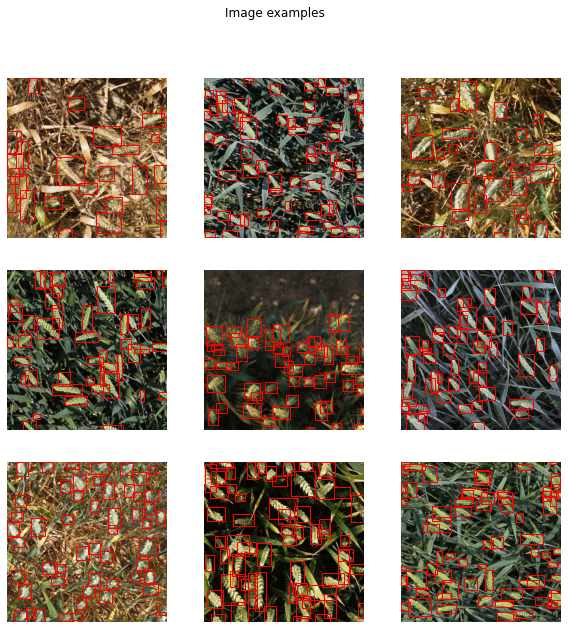

In [11]:
plot_image_examples(all_train_images)

We can see images taken at different lighting conditions and plant maturity stages!

Count number of bounding boxes per image:

In [12]:
# compute the number of bounding boxes per train image
all_train_images['count'] = all_train_images.apply(lambda row: 1 if np.isfinite(row.width) else 0, axis=1)
train_images_count = all_train_images.groupby('image_id').sum().reset_index()

In [13]:
train_images_count
#train_images_count[train_images_count['image_id']=='00333207f']

image_id    width   height  bbox_xmin  bbox_ymin  bbox_width  \
0     00333207f  56320.0  56320.0    26091.0    23051.0      4792.0   
1     005b0d8bb  20480.0  20480.0     8635.0     9267.0      2739.0   
2     006a994f7  25600.0  25600.0    13033.0    11204.0      2856.0   
3     00764ad5d  41984.0  41984.0    18309.0    18637.0      3951.0   
4     00b5c6764      0.0      0.0        0.0        0.0         0.0   
...         ...      ...      ...        ...        ...         ...   
3417  ffbb9c623      0.0      0.0        0.0        0.0         0.0   
3418  ffbf75e5b  53248.0  53248.0    22647.0    23920.0      4454.0   
3419  ffbfe7cc0  34816.0  34816.0    17561.0    16490.0      2899.0   
3420  ffc870198  41984.0  41984.0    17754.0    18419.0      5078.0   
3421  ffdf83e42  39936.0  39936.0    17112.0    22335.0      3118.0   

      bbox_height  count  
0          3846.0     55  
1          2410.0     20  
2          2835.0     25  
3          3361.0     41  
4             0.0      0  
...           ...    ...  
3417          0.0      0  
3418       4691.0     52  
3419       3040.0     34  
3420       3765.0     41  
3421       2684.0     39  

[3422 rows x 8 columns]

In [14]:
# See this article on how to plot bar charts with Bokeh:
# https://towardsdatascience.com/interactive-histograms-with-bokeh-202b522265f3
def hist_hover(dataframe, column, colors=["#94c8d8", "#ea5e51"], bins=30, title=''):
    hist, edges = np.histogram(dataframe[column], bins = bins)
    
    hist_df = pd.DataFrame({column: hist,
                             "left": edges[:-1],
                             "right": edges[1:]})
    hist_df["interval"] = ["%d to %d" % (left, right) for left, 
                           right in zip(hist_df["left"], hist_df["right"])]

    src = ColumnDataSource(hist_df)
    plot = figure(plot_height = 400, plot_width = 600,
          title = title,
          x_axis_label = column,
          y_axis_label = "Count")    
    plot.quad(bottom = 0, top = column,left = "left", 
        right = "right", source = src, fill_color = colors[0], 
        line_color = "#35838d", fill_alpha = 0.7,
        hover_fill_alpha = 0.7, hover_fill_color = colors[1])
        
    hover = HoverTool(tooltips = [('Interval', '@interval'),
                              ('Count', str("@" + column))])
    plot.add_tools(hover)
    
    output_notebook()
    show(plot)

In [15]:
hist_hover(train_images_count, 'count', title='Number of wheat spikes per image')

Loading BokehJS ...

Most of the images have 20-50 wheat spikes on them.

Let's plot some examples with small number of spikes per image:

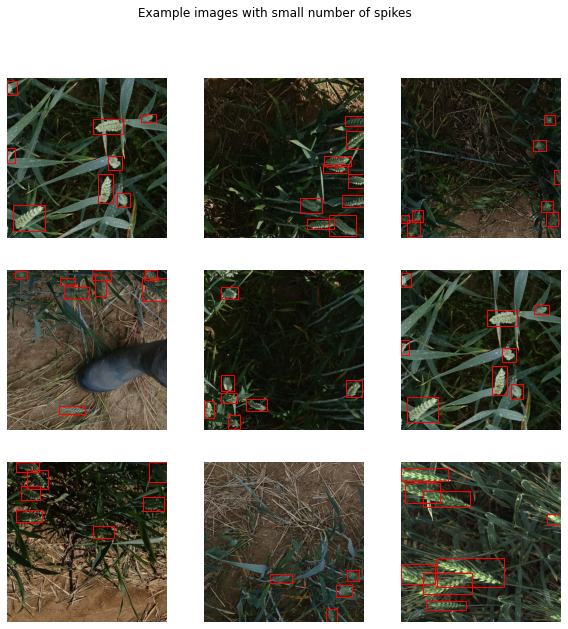

In [16]:
# bboxの数が少ないイメージをいくつか描画
less_spikes_ids = train_images_count[train_images_count['count'] < 10].image_id
plot_image_examples(all_train_images[all_train_images.image_id.isin(less_spikes_ids)], title='Example images with small number of spikes')

These are some very strange examples:
* いくつかのイメージは土が見えている
* いくつかのイメージは極端にズームされている

Plot the images with many spikes:

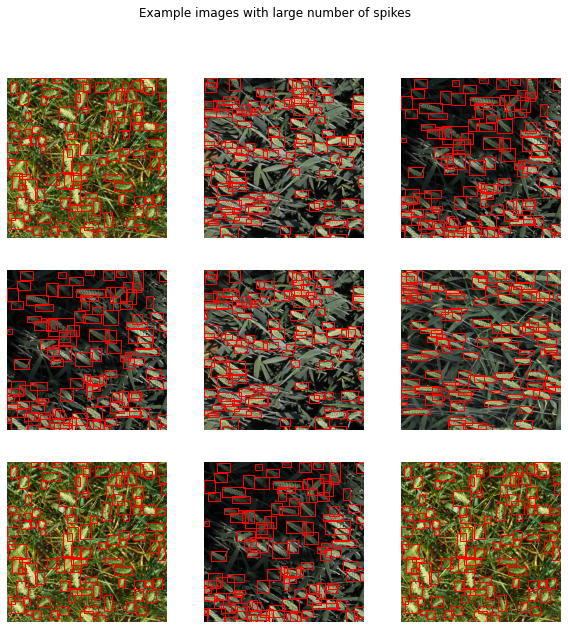

In [17]:
many_spikes_ids = train_images_count[train_images_count['count'] > 100].image_id
plot_image_examples(all_train_images[all_train_images.image_id.isin(many_spikes_ids)], title='Example images with large number of spikes')

These actually look much better than those with small number of spikes.

`3` Area of bounding boxes:

In [18]:
# compute bounding box areas
all_train_images['bbox_area'] = all_train_images['bbox_width'] * all_train_images['bbox_height']

In [19]:
# plot a histogram of bounding box areas
hist_hover(all_train_images, 'bbox_area', title='Area of a single bounding box')

Loading BokehJS ...

The maximum area of bounding box:

In [20]:
all_train_images.bbox_area.max()

529788.0

The distribution of individual areas of bounding boxes has a very long tail. It would be interesting to look at the images with those large bounding boxes.

Let's plot some examples of large bounding boxes:

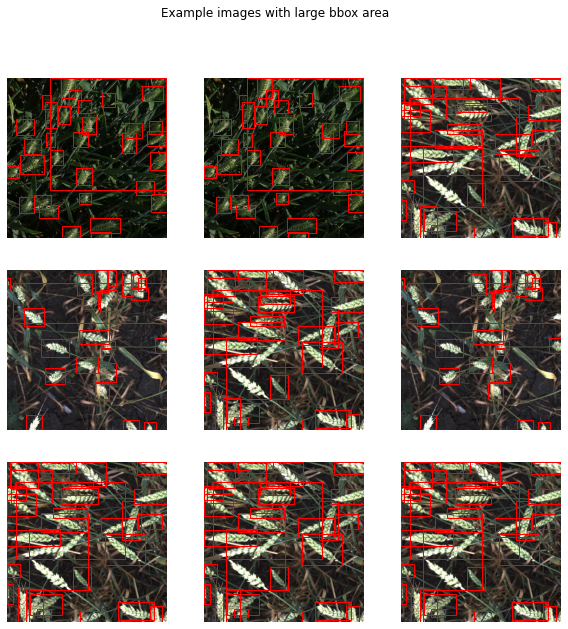

In [21]:
large_boxes_ids = all_train_images[(all_train_images['bbox_area'] > 200000)].image_id
plot_image_examples(all_train_images[all_train_images.image_id.isin(large_boxes_ids)], title='Example images with large bbox area')

__What are these anomally large bounding boxes?? I think those should be removed while training!!!__

Similarly, let's look at very small bounding boxes:

In [22]:
all_train_images[all_train_images['bbox_area'] > 15000]

image_id   width  height                          bbox     source  \
57      e5b2763a1  1024.0  1024.0    [792.0, 10.0, 161.0, 95.0]     ethz_1   
190     b9d5a380d  1024.0  1024.0    [16.0, 294.0, 210.0, 76.0]     ethz_1   
327     d25b61e9f  1024.0  1024.0   [174.0, 31.0, 125.0, 128.0]     ethz_1   
465     452fe4932  1024.0  1024.0   [649.0, 704.0, 94.0, 176.0]     ethz_1   
504     452fe4932  1024.0  1024.0   [490.0, 480.0, 182.0, 89.0]     ethz_1   
...           ...     ...     ...                           ...        ...   
147744  0cbcaf240  1024.0  1024.0  [604.0, 426.0, 202.0, 105.0]    inrae_1   
147806  fefd59985  1024.0  1024.0          [218, 858, 171, 100]  arvalis_1   
147812  fefd59985  1024.0  1024.0           [448, 311, 95, 189]  arvalis_1   
147814  fefd59985  1024.0  1024.0          [622, 460, 119, 161]  arvalis_1   
147836  fefd59985  1024.0  1024.0           [866, 694, 158, 97]  arvalis_1   

        bbox_xmin  bbox_ymin  bbox_width  bbox_height  count  bbox_area  
57          792.0       10.0       161.0         95.0      1    15295.0  
190          16.0      294.0       210.0         76.0      1    15960.0  
327         174.0       31.0       125.0        128.0      1    16000.0  
465         649.0      704.0        94.0        176.0      1    16544.0  
504         490.0      480.0       182.0         89.0      1    16198.0  
...           ...        ...         ...          ...    ...        ...  
147744      604.0      426.0       202.0        105.0      1    21210.0  
147806      218.0      858.0       171.0        100.0      1    17100.0  
147812      448.0      311.0        95.0        189.0      1    17955.0  
147814      622.0      460.0       119.0        161.0      1    19159.0  
147836      866.0      694.0       158.0         97.0      1    15326.0  

[9007 rows x 11 columns]

In [23]:
min_area = all_train_images[all_train_images['bbox_area'] > 0].bbox_area.min()
print('The smallest bounding box area is {}'.format(min_area))

The smallest bounding box area is 2.0


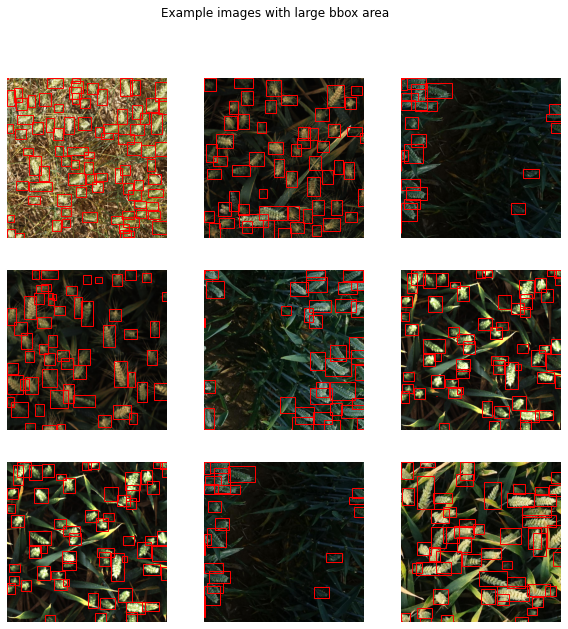

In [24]:
small_boxes_ids = all_train_images[(all_train_images['bbox_area'] < 50) & (all_train_images['bbox_area'] > 0)].image_id
plot_image_examples(all_train_images[all_train_images.image_id.isin(small_boxes_ids)], title='Example images with large bbox area')

If you look very close, you can probably see those tinyest bounding boxes near the corners and borders of the images. Probably, the boundries were drawn first, than the images were cut into several ones. That is why we see those strange small bounsing boxes in the corners.

It is not necessary to clean these, because they won't have much effect on the IOU metric.

よく見ると、画像の四隅や境界線の近くに小さな境界線があるのがわかると思います。おそらく、画像をいくつかの画像に切り分けるよりも、先に境界線を描いたのでしょう。そのため、画像の角に奇妙な小さな箱が見えているのです。

これらは IOU メトリックにはあまり影響しないので、きれいにする必要はありません。

`4` Area of bounding boxes per image:

In [25]:
# compute the total bounding boxes area per image
area_per_image = all_train_images.groupby(by='image_id').sum().reset_index()

# compute the percentage of the image area covered by bounding boxes
area_per_image_percentage = area_per_image.copy()
area_per_image_percentage['bbox_area'] = area_per_image_percentage['bbox_area'] / (1024*1024) * 100
area_per_image_percentage.head()

image_id    width   height  bbox_xmin  bbox_ymin  bbox_width  bbox_height  \
0  00333207f  56320.0  56320.0    26091.0    23051.0      4792.0       3846.0   
1  005b0d8bb  20480.0  20480.0     8635.0     9267.0      2739.0       2410.0   
2  006a994f7  25600.0  25600.0    13033.0    11204.0      2856.0       2835.0   
3  00764ad5d  41984.0  41984.0    18309.0    18637.0      3951.0       3361.0   
4  00b5c6764      0.0      0.0        0.0        0.0         0.0          0.0   

   count  bbox_area  
0     55  33.440208  
1     20  30.729389  
2     25  31.012440  
3     41  31.554317  
4      0   0.000000

In [26]:
hist_hover(area_per_image_percentage, 'bbox_area', title='Percentage of image area covered by bounding boxes')

Loading BokehJS ...

This looks like a nice normal distribution! 20-40% of the image area is covered by the bounding boxes.

This observation can be used to validate the predictions of the resulting model. The percentage of predicted bounding boxes area should be normally distributed too.

We can also see that the maximum is actually greater than 100%. This means that the bounding boxes are overlapping.

これはいい感じの正規分布に見えますね! 画像領域の20-40%がバウンディングボックスで覆われています。

この観測は、結果として得られるモデルの予測を検証するために使用できます。予測されたバウンディングボックスの面積の割合も正規分布になっているはずです。

また、最大値が実際には100%よりも大きいことがわかります。これは、バウンディングボックスが重なっていることを意味します。

Let's look at some examples of images with small areas covered by bounding boxes:

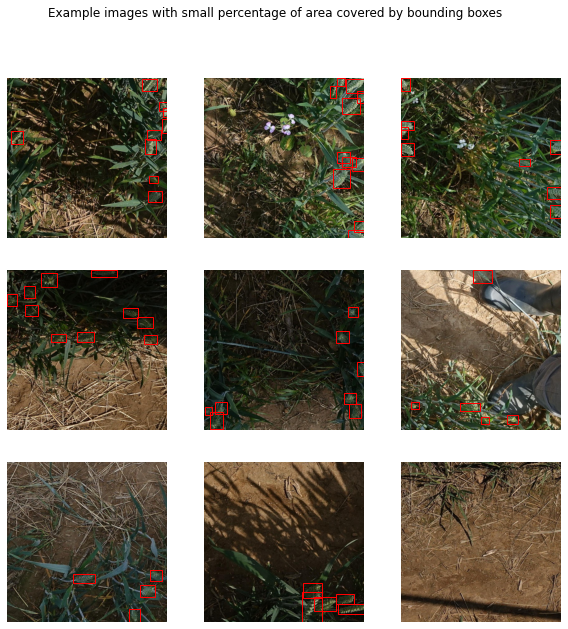

In [27]:
small_area_perc_ids = area_per_image_percentage[area_per_image_percentage['bbox_area'] < 7].image_id
plot_image_examples(all_train_images[all_train_images.image_id.isin(small_area_perc_ids)], title='Example images with small percentage of area covered by bounding boxes')

Now let's plot the images with large areas covered by bounding boxes:

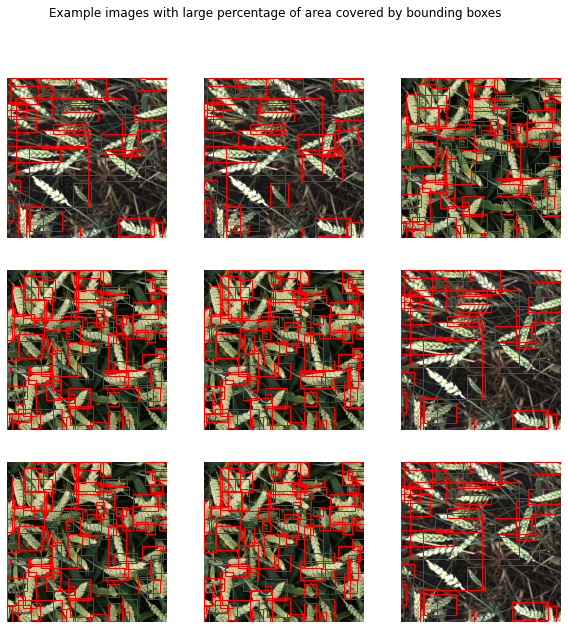

In [28]:
large_area_perc_ids = area_per_image_percentage[area_per_image_percentage['bbox_area'] > 95].image_id
plot_image_examples(all_train_images[all_train_images.image_id.isin(large_area_perc_ids)], title='Example images with large percentage of area covered by bounding boxes')

`5` The brightness of the images:

In [29]:
def get_image_brightness(image):
    # convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # get average brightness
    return np.array(gray).mean()

def add_brightness(df):
    brightness = []
    for _, row in df.iterrows():
        img_id = row.image_id  
        image = cv2.imread(TRAIN_DIR + img_id + '.jpg')
        brightness.append(get_image_brightness(image))
        
    brightness_df = pd.DataFrame(brightness)
    brightness_df.columns = ['brightness']
    df = pd.concat([df, brightness_df], ignore_index=True, axis=1)
    df.columns = ['image_id', 'brightness']
    
    return df

In [30]:
images_df = pd.DataFrame(all_train_images.image_id.unique())
images_df.columns = ['image_id']
images_df.head()

image_id
0  e5b2763a1
1  32a203fe5
2  b9d5a380d
3  8a5c7ac65
4  948c989ef

In [31]:
# imageの明度
images_df = pd.DataFrame(all_train_images.image_id.unique())
images_df.columns = ['image_id']
brightness_df = add_brightness(images_df)

all_train_images = all_train_images.merge(brightness_df, on='image_id')

In [32]:
all_train_images.head()

image_id   width  height                         bbox  source  bbox_xmin  \
0  e5b2763a1  1024.0  1024.0  [796.0, 23.0, 117.0, 114.0]  ethz_1      796.0   
1  e5b2763a1  1024.0  1024.0   [961.0, 417.0, 63.0, 84.0]  ethz_1      961.0   
2  e5b2763a1  1024.0  1024.0  [395.0, 167.0, 120.0, 70.0]  ethz_1      395.0   
3  e5b2763a1  1024.0  1024.0   [441.0, 637.0, 99.0, 63.0]  ethz_1      441.0   
4  e5b2763a1  1024.0  1024.0    [757.0, 73.0, 70.0, 81.0]  ethz_1      757.0   

   bbox_ymin  bbox_width  bbox_height  count  bbox_area  brightness  
0       23.0       117.0        114.0      1    13338.0   68.470679  
1      417.0        63.0         84.0      1     5292.0   68.470679  
2      167.0       120.0         70.0      1     8400.0   68.470679  
3      637.0        99.0         63.0      1     6237.0   68.470679  
4       73.0        70.0         81.0      1     5670.0   68.470679

In [33]:
hist_hover(all_train_images, 'brightness', title='Images brightness distribution')

Loading BokehJS ...

Plot the darkest images:

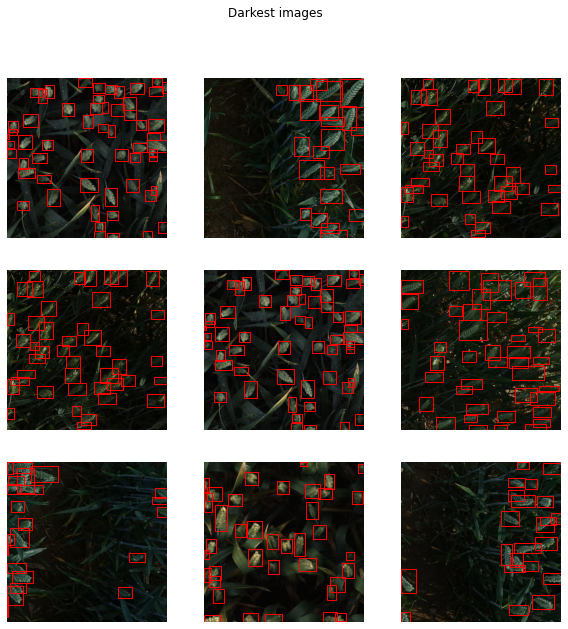

In [34]:
dark_ids = all_train_images[all_train_images['brightness'] < 30].image_id
plot_image_examples(all_train_images[all_train_images.image_id.isin(dark_ids)], title='Darkest images')

On some of the images, it is even hard for human to see the spikes!

Plot the brightest images:

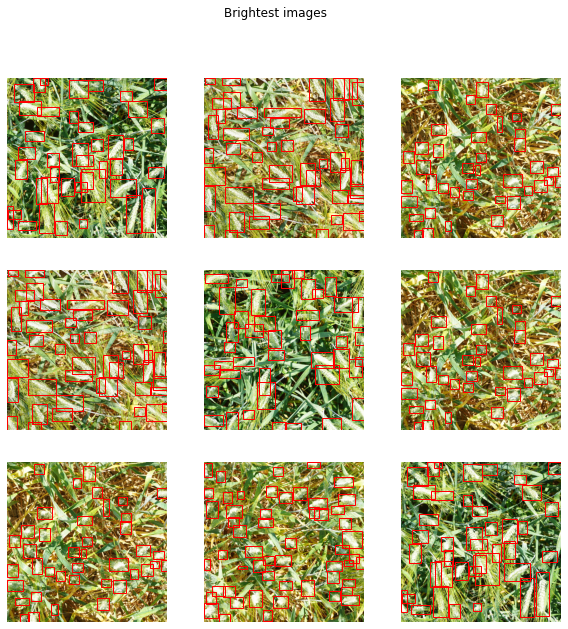

In [35]:
bright_ids = all_train_images[all_train_images['brightness'] > 130].image_id
plot_image_examples(all_train_images[all_train_images.image_id.isin(bright_ids)], title='Brightest images')

These are very different from the dark ones. Some filters needed here to make the spikes more clear.

I also see the missing boundaries.

* くらいイメージ：明度をあげる
* 明るいイメージ：明度を下げる。協会がわかりやすくなるようにする

`6` The most and the least green and yellow images:

I would like to plot images with different dominant colors. The idea is that the most green images will represent healthy plants. The most yellow images will contain plants close to maturity. The most brown images will have ground on them.

支配色の異なる画像をプロットしたいと思います。最も緑の画像は健康な植物を表します。最も黄色の画像には、成熟期に近い植物が含まれています。茶色の画像は地面があることを表しています。

In [36]:
def get_percentage_of_green_pixels(image):
    # convert to HSV
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    # get the green mask
    hsv_lower = (40, 40, 40) 
    hsv_higher = (70, 255, 255)
    green_mask = cv2.inRange(hsv, hsv_lower, hsv_higher)
    
    return float(np.sum(green_mask)) / 255 / (1024 * 1024)

def get_percentage_of_yellow_pixels(image):
    # convert to HSV
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    # get the green mask
    hsv_lower = (25, 40, 40) 
    hsv_higher = (35, 255, 255)
    yellow_mask = cv2.inRange(hsv, hsv_lower, hsv_higher)
    
    return float(np.sum(yellow_mask)) / 255 / (1024 * 1024)

def add_green_pixels_percentage(df):
    green = []
    for _, row in df.iterrows():
        img_id = row.image_id  
        image = cv2.imread(TRAIN_DIR + img_id + '.jpg')
        green.append(get_percentage_of_green_pixels(image))
        
    green_df = pd.DataFrame(green)
    green_df.columns = ['green_pixels']
    df = pd.concat([df, green_df], ignore_index=True, axis=1)
    df.columns = ['image_id', 'green_pixels']
    
    return df

def add_yellow_pixels_percentage(df):
    yellow = []
    for _, row in df.iterrows():
        img_id = row.image_id  
        image = cv2.imread(TRAIN_DIR + img_id + '.jpg')
        yellow.append(get_percentage_of_yellow_pixels(image))
        
    yellow_df = pd.DataFrame(yellow)
    yellow_df.columns = ['yellow_pixels']
    df = pd.concat([df, yellow_df], ignore_index=True, axis=1)
    df.columns = ['image_id', 'yellow_pixels']
    
    return df

In [37]:
# add a column with the percentage of green pixels
green_pixels_df = add_green_pixels_percentage(images_df)
all_train_images = all_train_images.merge(green_pixels_df, on='image_id')

In [38]:
hist_hover(all_train_images, 'green_pixels', title='Percentage of green pixels distribution', colors=['#c3ea84', '#3e7a17'])

Loading BokehJS ...

Surprisingly, the most green images have only aoung 60% green pixels.

The majority of the images are not green at all! Most probably, they are more yellow and are the images of the plants close to harvest.

驚くべきことに、最も緑の多い画像は、緑の画素数が60％程度しかありません。

画像の大部分は全く緑色ではありません。おそらく、これらの画像は黄色が多く、収穫間近の植物の画像なのでしょう。

The most green images:

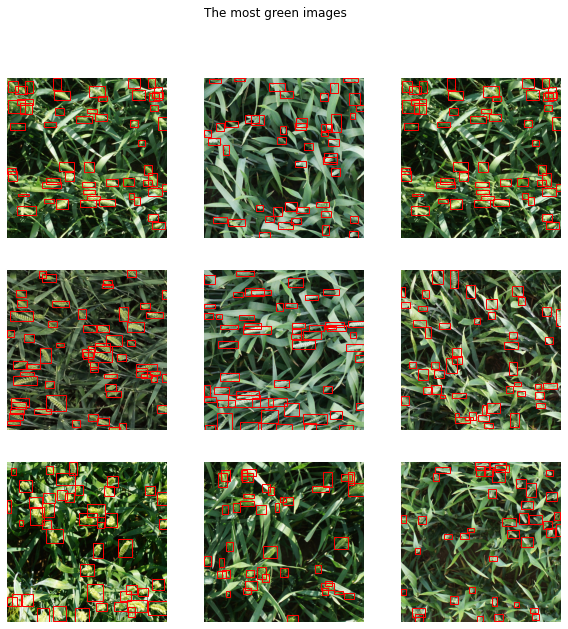

In [39]:
green_ids = all_train_images[all_train_images['green_pixels'] > 0.55].image_id
plot_image_examples(all_train_images[all_train_images.image_id.isin(green_ids)], title='The most green images')

The most green images mostly contain the plants with very small spikes, which are just starting to appear.

In [40]:
# add a column with the percentage of yellow pixels
yellow_pixels_df = add_yellow_pixels_percentage(images_df)
all_train_images = all_train_images.merge(yellow_pixels_df, on='image_id')

In [41]:
hist_hover(all_train_images, 'yellow_pixels', title='Percentage of yellow pixels distribution', colors=['#fffedb', '#fffeab'])

Loading BokehJS ...

Let's look at the most yellow images:

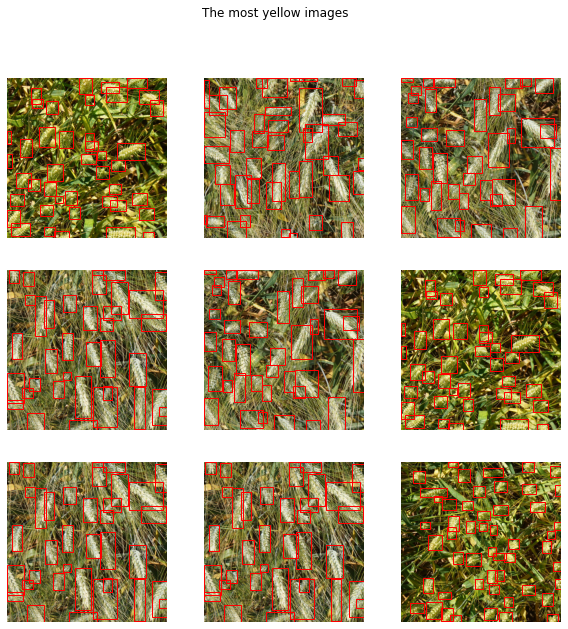

In [42]:
yellow_ids = all_train_images[all_train_images['yellow_pixels'] > 0.55].image_id
plot_image_examples(all_train_images[all_train_images.image_id.isin(yellow_ids)], title='The most yellow images')

## Thoughts on Data Augmentation

Data augmentation is critical in this competition, because there is a relatively small training set. Data augmentation will allow to build robust models under given circumstances.
What augmentations/filers might work:
* flipping images horizontally and vertically, because the orientation of original images is different;
* crop-resize, because we can see spikes at different zoom levels;
* different filters to adjust the lighting conditions. I suggest looking at [this competition](https://www.kaggle.com/c/aptos2019-blindness-detection) for example.

What to do with caution:
* rotation might not work, because rotation messes up the bounding boxes.

Example augmentation pipeline:

In [43]:
# setup an example augmentation pipeline
# be sure to use bbox safe functions for data augmentation
example_transforms = albu.Compose([
    albu.RandomSizedBBoxSafeCrop(512, 512, erosion_rate=0.0, interpolation=1, p=1.0),
    albu.HorizontalFlip(p=0.5),
    albu.VerticalFlip(p=0.5),
    albu.OneOf([albu.RandomContrast(),
                albu.RandomGamma(),
                albu.RandomBrightness()], p=1.0),
    albu.CLAHE(p=1.0)], p=1.0, bbox_params=albu.BboxParams(format='coco', label_fields=['category_id']))

In [44]:
def apply_transforms(transforms, df, n_transforms=3):
    idx = np.random.randint(len(df), size=1)[0]
    
    image_id = df.iloc[idx].image_id
    bboxes = []
    for _, row in df[df.image_id == image_id].iterrows():
        bboxes.append([row.bbox_xmin, row.bbox_ymin, row.bbox_width, row.bbox_height])
        
    image = Image.open(TRAIN_DIR + image_id + '.jpg')
    
    fig, axs = plt.subplots(1, n_transforms+1, figsize=(15,7))
    
    # plot the original image
    axs[0].imshow(image)
    axs[0].set_title('original')
    for bbox in bboxes:
        rect = patches.Rectangle((bbox[0],bbox[1]),bbox[2],bbox[3],linewidth=1,edgecolor='r',facecolor='none')
        axs[0].add_patch(rect)
    
    # apply transforms n_transforms times
    for i in range(n_transforms):
        params = {'image': np.asarray(image),
                  'bboxes': bboxes,
                  'category_id': [1 for j in range(len(bboxes))]}
        augmented_boxes = transforms(**params)
        bboxes_aug = augmented_boxes['bboxes']
        image_aug = augmented_boxes['image']

        # plot the augmented image and augmented bounding boxes
        axs[i+1].imshow(image_aug)
        axs[i+1].set_title('augmented_' + str(i+1))
        for bbox in bboxes_aug:
            rect = patches.Rectangle((bbox[0],bbox[1]),bbox[2],bbox[3],linewidth=1,edgecolor='r',facecolor='none')
            axs[i+1].add_patch(rect)
    plt.show()

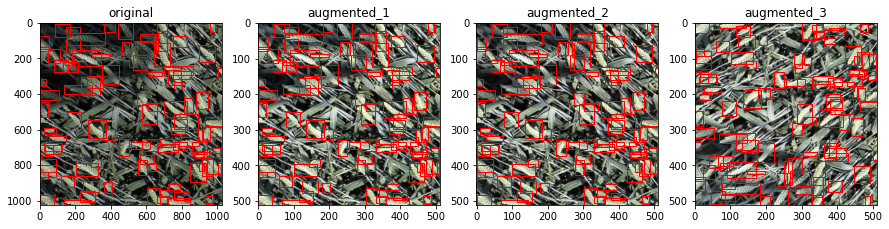

In [45]:
apply_transforms(example_transforms, all_train_images, n_transforms=3)

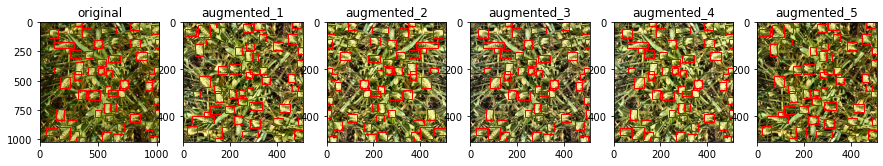

In [46]:
#apply_transforms(example_transforms, all_train_images, n_transforms=3)
apply_transforms(example_transforms, all_train_images[all_train_images.image_id.isin(yellow_ids)], n_transforms=5)

Note how CLAHE emphasizes the features in darker spots. It is a must have for this competition.

## Conclusions:

1. Images are taken at different zoom levels. Crop and resize data augmentations to be used for model training.
2. Images are taken at various lighting conditions. Special filters should be used to address that.
3. Bounding boxes are messy! 
    * Giant bounding boxes should be filtered out by area and removed before model training.
    * Micro bounding boxes. These can stay. They won't have much effect on the IOU metric.
    * Some spikes are not surrounded by a bounding box (missing bounding boxes).

# train_csv

In [47]:
!pip install --no-deps '../input/timm_package/timm-0.1.26-py3-none-any.whl' > /dev/null
!pip install --no-deps '../input/pycocotools/pycocotools-2.0-cp37-cp37m-linux_x86_64.whl' > /dev/null

In [48]:
import sys
sys.path.insert(0, "../input/timm_efficientdet_pytorch")
sys.path.insert(0, "../input/omegaconf")

import torch
import os
from datetime import datetime
import time
import random
import cv2
import pandas as pd
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch.transforms import ToTensorV2
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from glob import glob

SEED = 777
N_SPLITS = 3

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

marking = all_train_images.copy()
marking = marking.rename(columns={'bbox_xmin': 'x', 'bbox_ymin': 'y', 'bbox_width': 'w', 'bbox_height': 'h'})

In [49]:
# データ整形
## 面積の大きいbboxを削除
def delete_bbox(df):
    # でかいbbox, 面積0のbboxを除去
    th=200000
    df = df[(1 < df['bbox_area']) & (df['bbox_area'] < th)]
    return df

print(len(marking))
marking = delete_bbox(marking)
print(len(marking))

147842
147787


In [50]:
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=777)

df_folds = marking[['image_id']].copy()
df_folds.loc[:, 'bbox_count'] = 1
df_folds = df_folds.groupby('image_id').count()
df_folds.loc[:, 'source'] = marking[['image_id', 'source']].groupby('image_id').min()['source']
df_folds.loc[:, 'stratify_group'] = np.char.add(
    df_folds['source'].values.astype(str),
    df_folds['bbox_count'].apply(lambda x: f'_{x // 15}').values.astype(str)
)
df_folds.loc[:, 'fold'] = 0

In [51]:
df_folds

bbox_count     source stratify_group  fold
image_id                                             
00333207f          55  arvalis_1    arvalis_1_3     0
005b0d8bb          20    usask_1      usask_1_1     0
006a994f7          25    inrae_1      inrae_1_1     0
00764ad5d          41    inrae_1      inrae_1_2     0
00b5fefed          25  arvalis_3    arvalis_3_1     0
...               ...        ...            ...   ...
ffb445410          57     rres_1       rres_1_3     0
ffbf75e5b          52  arvalis_1    arvalis_1_3     0
ffbfe7cc0          34  arvalis_1    arvalis_1_2     0
ffc870198          41    usask_1      usask_1_2     0
ffdf83e42          39  arvalis_1    arvalis_1_2     0

[3373 rows x 4 columns]

In [52]:
for fold_number, (train_index, val_index) in enumerate(skf.split(X=df_folds.index, y=df_folds['stratify_group'])):
    df_folds.loc[df_folds.iloc[val_index].index, 'fold'] = fold_number

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


In [53]:
df_folds.head()

bbox_count     source stratify_group  fold
image_id                                             
00333207f          55  arvalis_1    arvalis_1_3     3
005b0d8bb          20    usask_1      usask_1_1     4
006a994f7          25    inrae_1      inrae_1_1     3
00764ad5d          41    inrae_1      inrae_1_2     0
00b5fefed          25  arvalis_3    arvalis_3_1     2

# 水増し

In [54]:
def get_train_transforms():
    return A.Compose(
        [
            A.RandomSizedCrop(min_max_height=(800, 800), height=1024, width=1024, p=0.5),
            A.OneOf([
                A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, 
                                     val_shift_limit=0.2, p=0.9),
                A.RandomBrightnessContrast(brightness_limit=0.2, 
                                           contrast_limit=0.2, p=0.9),
                A.RandomGamma(),
            ],p=0.9),
            #A.CLAHE(p=1.0),
            A.ToGray(p=0.01),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.Resize(height=512, width=512, p=1),
            A.Cutout(num_holes=8, max_h_size=64, max_w_size=64, fill_value=0, p=0.5),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

def get_valid_transforms():
    return A.Compose(
        [
            A.Resize(height=512, width=512, p=1.0),
            #A.CLAHE(p=1.0),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

In [55]:
#test autmentation :TODO
#apply_transforms(get_train_transforms(), all_train_images, n_transforms=3)

# Dataset

In [56]:
TRAIN_ROOT_PATH = '../input/raw/train'

class DatasetRetriever(Dataset):

    def __init__(self, marking, image_ids, transforms=None, test=False):
        super().__init__()

        self.image_ids = image_ids
        self.marking = marking
        self.transforms = transforms
        self.test = test

    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        
        if self.test or random.random() > 0.5:
            image, boxes = self.load_image_and_boxes(index)
        else:
            image, boxes = self.load_cutmix_image_and_boxes(index)
#         else:
#             image, boxes = self.load_mixup_image_and_boxes(index)

        # there is only one class
        labels = torch.ones((boxes.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([index])

        if self.transforms:
            for i in range(10):
                sample = self.transforms(**{
                    'image': image,
                    'bboxes': target['boxes'],
                    'labels': labels
                })
                if len(sample['bboxes']) > 0:
                    image = sample['image']
                    target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
                    target['boxes'][:,[0,1,2,3]] = target['boxes'][:,[1,0,3,2]]  #yxyx: be warning
                    break

        return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

    def load_image_and_boxes(self, index):
        image_id = self.image_ids[index]
        image = cv2.imread(f'{TRAIN_ROOT_PATH}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        records = self.marking[self.marking['image_id'] == image_id]
        boxes = records[['x', 'y', 'w', 'h']].values
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        return image, boxes

    def load_cutmix_image_and_boxes(self, index, imsize=1024):
        """ 
        This implementation of cutmix author:  https://www.kaggle.com/nvnnghia 
        Refactoring and adaptation: https://www.kaggle.com/shonenkov
        https://www.kaggle.com/shonenkov/oof-evaluation-mixup-efficientdet　のMixup #3に対応
        """

        w, h = imsize, imsize
        s = imsize // 2
    
        xc, yc = [int(random.uniform(imsize * 0.25, imsize * 0.75)) for _ in range(2)]  # center x, y
        indexes = [index] + [random.randint(0, self.image_ids.shape[0] - 1) for _ in range(3)]

        result_image = np.full((imsize, imsize, 3), 1, dtype=np.float32)
        result_boxes = []

        for i, index in enumerate(indexes):
            image, boxes = self.load_image_and_boxes(index)
            if i == 0:
                x1a, y1a, x2a, y2a = max(xc - w, 0), max(yc - h, 0), xc, yc  # xmin, ymin, xmax, ymax (large image)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), h - (y2a - y1a), w, h  # xmin, ymin, xmax, ymax (small image)
            elif i == 1:  # top right
                x1a, y1a, x2a, y2a = xc, max(yc - h, 0), min(xc + w, s * 2), yc
                x1b, y1b, x2b, y2b = 0, h - (y2a - y1a), min(w, x2a - x1a), h
            elif i == 2:  # bottom left
                x1a, y1a, x2a, y2a = max(xc - w, 0), yc, xc, min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), 0, max(xc, w), min(y2a - y1a, h)
            elif i == 3:  # bottom right
                x1a, y1a, x2a, y2a = xc, yc, min(xc + w, s * 2), min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = 0, 0, min(w, x2a - x1a), min(y2a - y1a, h)
            result_image[y1a:y2a, x1a:x2a] = image[y1b:y2b, x1b:x2b]
            padw = x1a - x1b
            padh = y1a - y1b

            boxes[:, 0] += padw
            boxes[:, 1] += padh
            boxes[:, 2] += padw
            boxes[:, 3] += padh

            result_boxes.append(boxes)

        result_boxes = np.concatenate(result_boxes, 0)
        np.clip(result_boxes[:, 0:], 0, 2 * s, out=result_boxes[:, 0:])
        result_boxes = result_boxes.astype(np.int32)
        result_boxes = result_boxes[np.where((result_boxes[:,2]-result_boxes[:,0])*(result_boxes[:,3]-result_boxes[:,1]) > 0)]
        return result_image, result_boxes
    
    def load_mixup_image_and_boxes(self, index, imsize=1024):
        result_boxes = []
        image, boxes = self.load_image_and_boxes(index)
        r_image, r_boxes = self.load_image_and_boxes(random.randint(0, self.image_ids.shape[0] - 1))
        mixup_image = (image+r_image)/2

        result_image = mixup_image.copy()
        result_boxes.append(boxes)
        result_boxes.append(r_boxes)
        
        return result_image, np.array(result_boxes)

# Fitter

In [57]:
#Fitter
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [58]:
import warnings
warnings.filterwarnings("ignore")

class Fitter:
    
    def __init__(self, model, device, config):
        self.config = config
        self.epoch = 0

        self.base_dir = f'./{config.folder}'
        if not os.path.exists(self.base_dir):
            os.makedirs(self.base_dir)
        
        self.log_path = f'{self.base_dir}/log.txt'
        self.best_summary_loss = 10**5

        self.model = model
        self.device = device

        param_optimizer = list(self.model.named_parameters())
        no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.001},
            {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ] 

        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=config.lr)
        self.scheduler = config.SchedulerClass(self.optimizer, **config.scheduler_params)
        self.log(f'Fitter prepared. Device is {self.device}')

    def fit(self, train_loader, validation_loader):
        for e in range(self.config.n_epochs):
            if self.config.verbose:
                lr = self.optimizer.param_groups[0]['lr']
                timestamp = datetime.utcnow().isoformat()
                self.log(f'\n{timestamp}\nLR: {lr}')

            t = time.time()
            summary_loss = self.train_one_epoch(train_loader)

            self.log(f'[RESULT]: Train. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, time: {(time.time() - t):.5f}')
            self.save(f'{self.base_dir}/last-checkpoint.bin')

            t = time.time()
            summary_loss = self.validation(validation_loader)

            self.log(f'[RESULT]: Val. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, time: {(time.time() - t):.5f}')
            if summary_loss.avg < self.best_summary_loss:
                self.best_summary_loss = summary_loss.avg
                self.model.eval()
                self.save(f'{self.base_dir}/best-checkpoint-{str(self.epoch).zfill(3)}epoch.bin')
                for path in sorted(glob(f'{self.base_dir}/best-checkpoint-*epoch.bin'))[:-3]:
                    os.remove(path)

            if self.config.validation_scheduler:
                self.scheduler.step(metrics=summary_loss.avg)

            self.epoch += 1

    def validation(self, val_loader):
        self.model.eval()
        summary_loss = AverageMeter()
        t = time.time()
        for step, (images, targets, image_ids) in enumerate(val_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Val Step {step}/{len(val_loader)}, ' + \
                        f'summary_loss: {summary_loss.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}', end='\r'
                    )
            with torch.no_grad():
                images = torch.stack(images)
                batch_size = images.shape[0]
                images = images.to(self.device).float()
                boxes = [target['boxes'].to(self.device).float() for target in targets]
                labels = [target['labels'].to(self.device).float() for target in targets]

                loss, _, _ = self.model(images, boxes, labels)
                summary_loss.update(loss.detach().item(), batch_size)

        return summary_loss

    def train_one_epoch(self, train_loader):
        self.model.train()
        summary_loss = AverageMeter()
        t = time.time()
        for step, (images, targets, image_ids) in enumerate(train_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Train Step {step}/{len(train_loader)}, ' + \
                        f'summary_loss: {summary_loss.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}', end='\r'
                    )
            
            images = torch.stack(images)
            images = images.to(self.device).float()
            batch_size = images.shape[0]
            boxes = [target['boxes'].to(self.device).float() for target in targets]
            labels = [target['labels'].to(self.device).float() for target in targets]

            self.optimizer.zero_grad()
            
            loss, _, _ = self.model(images, boxes, labels)
            
            loss.backward()

            summary_loss.update(loss.detach().item(), batch_size)

            self.optimizer.step()

            if self.config.step_scheduler:
                self.scheduler.step()

        return summary_loss
    
    def save(self, path):
        self.model.eval()
        torch.save({
            'model_state_dict': self.model.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'best_summary_loss': self.best_summary_loss,
            'epoch': self.epoch,
        }, path)

    def load(self, path):
        checkpoint = torch.load(path)
        self.model.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        self.best_summary_loss = checkpoint['best_summary_loss']
        self.epoch = checkpoint['epoch'] + 1
        
    def log(self, message):
        if self.config.verbose:
            print(message)
        with open(self.log_path, 'a+') as logger:
            logger.write(f'{message}\n')

In [59]:
class TrainGlobalConfig:
    num_workers = 2
    batch_size = 4
    n_epochs = 60
    lr = 0.0002

    folder = '../output/model/effdet5-cutmix-augmix'

    # -------------------
    verbose = True
    verbose_step = 1
    # -------------------

    # --------------------
    step_scheduler = False  # do scheduler.step after optimizer.step
    validation_scheduler = True  # do scheduler.step after validation stage loss

#     SchedulerClass = torch.optim.lr_scheduler.OneCycleLR
#     scheduler_params = dict(
#         max_lr=0.001,
#         epochs=n_epochs,
#         steps_per_epoch=int(len(train_dataset) / batch_size),
#         pct_start=0.1,
#         anneal_strategy='cos', 
#         final_div_factor=10**5
#     )
    
    SchedulerClass = torch.optim.lr_scheduler.ReduceLROnPlateau
    scheduler_params = dict(
        mode='min',
        factor=0.5,
        patience=2,
        verbose=False, 
        threshold=0.0001,
        threshold_mode='abs',
        cooldown=0, 
        min_lr=1e-8,
        eps=1e-08
    )
    # --------------------

In [60]:
def collate_fn(batch):
    return tuple(zip(*batch))

def run_training(net, train_dataset, val_dataset,):
    device = torch.device('cuda:0')
    net.to(device)

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=TrainGlobalConfig.batch_size,
        sampler=RandomSampler(train_dataset),
        pin_memory=False,
        drop_last=True,
        num_workers=TrainGlobalConfig.num_workers,
        collate_fn=collate_fn,
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, 
        batch_size=TrainGlobalConfig.batch_size,
        num_workers=TrainGlobalConfig.num_workers,
        shuffle=False,
        sampler=SequentialSampler(val_dataset),
        pin_memory=False,
        collate_fn=collate_fn,
    )

    fitter = Fitter(model=net, device=device, config=TrainGlobalConfig)
    fitter.fit(train_loader, val_loader)

In [61]:
from effdet import get_efficientdet_config, EfficientDet, DetBenchTrain
from effdet.efficientdet import HeadNet

def get_net():
    config = get_efficientdet_config('tf_efficientdet_d5')
    net = EfficientDet(config, pretrained_backbone=False)
    checkpoint = torch.load('../input/efficientdet_pytorch/efficientdet_d5-ef44aea8.pth')
    net.load_state_dict(checkpoint)
    config.num_classes = 1
    config.image_size = 512
    net.class_net = HeadNet(config, num_outputs=config.num_classes, norm_kwargs=dict(eps=.001, momentum=.01))
    return DetBenchTrain(net, config)

In [62]:
def check_image():
    train_dataset = DatasetRetriever(
    image_ids=df_folds[df_folds['fold'] != 0].index.values,
    marking=marking,
    transforms=get_train_transforms(),
    test=False,
    )

    count = 4
    for i in range(count):
        image, boxes = train_dataset.load_mixup_image_and_boxes(random.randint(0, train_dataset.image_ids.shape[0] - 1))
        print(image.shape)
        plt.imshow(image)
        for b in boxes:
            for box in b.astype(int):
                cv2.rectangle(image,(box[0], box[1]),(box[2],  box[3]),(0, 0, 1), 3)
        plt.imshow(image)

# fold train

In [63]:
for fold_number in range(N_SPLITS):
    print(f'fold{fold_number}: train start')
    
    train_dataset = DatasetRetriever(
        image_ids=df_folds[df_folds['fold'] != fold_number].index.values,
        marking=marking,
        transforms=get_train_transforms(),
        test=False,
    )
    val_dataset = DatasetRetriever(
        image_ids=df_folds[df_folds['fold'] == fold_number].index.values,
        marking=marking,
        transforms=get_valid_transforms(),
        test=True,
    )
    # train model
    net = get_net()
    TrainGlobalConfig.folder = f'../output/model/effdet5-cutmix-augmix/fold{fold_number}'
    run_training(net, train_dataset, val_dataset)

#     image, target, image_id = train_dataset[1]
#     boxes = target['boxes'].cpu().numpy().astype(np.int32)

#     numpy_image = image.permute(1,2,0).cpu().numpy()

#     fig, ax = plt.subplots(1, 1, figsize=(16, 8))

#     for box in boxes:
#         cv2.rectangle(numpy_image, (box[1], box[0]), (box[3],  box[2]), (0, 1, 0), 2)

#     ax.set_axis_off()
#     ax.imshow(numpy_image)


fold0: train start
Fitter prepared. Device is cuda:0

2020-07-30T15:44:21.068197
LR: 0.0002
[RESULT]: Train. Epoch: 0, summary_loss: 1.69705, time: 653.70550
[RESULT]: Val. Epoch: 0, summary_loss: 0.45765, time: 44.23940

2020-07-30T15:56:00.331865
LR: 0.0002
[RESULT]: Train. Epoch: 1, summary_loss: 0.49618, time: 659.87784
[RESULT]: Val. Epoch: 1, summary_loss: 0.41484, time: 45.43746

2020-07-30T16:07:49.968467
LR: 0.0002
[RESULT]: Train. Epoch: 2, summary_loss: 0.47213, time: 662.46115
[RESULT]: Val. Epoch: 2, summary_loss: 0.40170, time: 42.97449

2020-07-30T16:19:39.545372
LR: 0.0002
[RESULT]: Train. Epoch: 3, summary_loss: 0.45736, time: 647.28533
[RESULT]: Val. Epoch: 3, summary_loss: 0.40090, time: 42.71917

2020-07-30T16:31:13.823332
LR: 0.0002
[RESULT]: Train. Epoch: 4, summary_loss: 0.44613, time: 650.83037
[RESULT]: Val. Epoch: 4, summary_loss: 0.38967, time: 42.66787

2020-07-30T16:42:51.753826
LR: 0.0002
[RESULT]: Train. Epoch: 5, summary_loss: 0.44539, time: 647.02148
[R

Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


KeyboardInterrupt: 